In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [2]:
# Mounting Google Drive to access files stored in Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load data
df = pd.read_csv('/content/drive/MyDrive/NLP_Project/IMDB_Dataset_Preprocessed.csv')

In [4]:
# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# 1. Define Custom Dataset Class
class NumpyDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.targets[idx]
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        return x, y

# 2. Define LSTM Model Class
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x.unsqueeze(1), (h0, c0))
        out = self.fc(out[:, -1, :])
        out = torch.sigmoid(out)
        return out

# 3. Training Loop
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.8f}')

# 4. Create Test Function
def test_model(model, test_loader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)
            outputs = model(inputs)
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    all_preds = np.concatenate(all_preds).flatten().round()
    all_targets = np.concatenate(all_targets).flatten()
    return all_targets, all_preds

# 5. Create Evaluation Function
def evaluate_model(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")

In [6]:
# Define Training Parameters
input_size = 768  # Number of features
hidden_size = 128  # Example hidden layer size
num_layers = 2 # Number of LSTM layers
output_size = 1 # Output size (single scalar value)
batch_size = 256 # Define Batch Size
num_epochs = 10 # Number of epochs

**RoBERTa**

In [7]:
# Loading data and Normalization
X_roberta = np.load('/content/drive/MyDrive/NLP_Project/X_roberta.npy')
print("RoBERTa Feature Shape:", X_roberta.shape)
scaler = StandardScaler()
model = scaler.fit(X_roberta)
X_roberta = model.transform(X_roberta)

RoBERTa Feature Shape: (50000, 768)


In [8]:
# Prepare Dataset
X_train, X_test, y_train, y_test = train_test_split(X_roberta, df['sentiment_numeric'].values, test_size=0.5, random_state=42)
print("Train Feature Shape:", X_train.shape)
print("Train Labels Shape:", y_train.shape)
print("Test Feature Shape:", X_test.shape)
print("Test Labels Shape:", y_test.shape)
train_dataset = NumpyDataset(X_train, y_train)
test_dataset = NumpyDataset(X_test, y_test)

Train Feature Shape: (25000, 768)
Train Labels Shape: (25000,)
Test Feature Shape: (25000, 768)
Test Labels Shape: (25000,)


In [9]:
# Prepare DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
# Instantiate Model, Define Loss and Optimizer
model = LSTMNetwork(input_size, hidden_size, num_layers, output_size)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Run Training Loops
train_model(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Loss: 0.08969279
Epoch [2/10], Loss: 0.11970105
Epoch [3/10], Loss: 0.06743158
Epoch [4/10], Loss: 0.07175634
Epoch [5/10], Loss: 0.05594188
Epoch [6/10], Loss: 0.05824358
Epoch [7/10], Loss: 0.00933051
Epoch [8/10], Loss: 0.01874436
Epoch [9/10], Loss: 0.02446622
Epoch [10/10], Loss: 0.01518180


LSTM with RoBERTa Features:
Accuracy: 0.85
Precision: 0.85
Recall: 0.84
F1-Score: 0.85


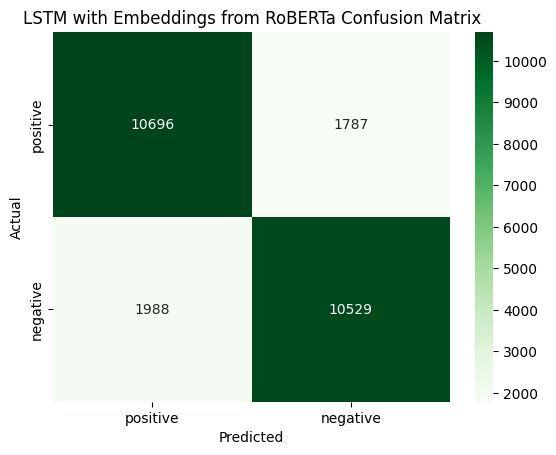

In [10]:
# Run Test
y_test, y_pre = test_model(model, test_loader)
print("LSTM with RoBERTa Features:")
evaluate_model(y_test, y_pre)
# Confusion matrix
textblob_cm = confusion_matrix(y_test, y_pre, labels=[0, 1])
sns.heatmap(textblob_cm, annot=True, fmt='d', cmap='Greens', xticklabels=['positive', 'negative'], yticklabels=['positive', 'negative'])
plt.title("LSTM with Embeddings from RoBERTa Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**DistilBERT**

In [11]:
# Loading data and Normalization
X_distilbert = np.load('/content/drive/MyDrive/NLP_Project/X_distilbert.npy')
print("DistilBERT Feature Shape:", X_distilbert.shape)
scaler = StandardScaler()
model = scaler.fit(X_distilbert)
X_distilbert = model.transform(X_distilbert)

DistilBERT Feature Shape: (50000, 768)


In [12]:
# Prepare Dataset
X_train, X_test, y_train, y_test = train_test_split(X_distilbert, df['sentiment_numeric'].values, test_size=0.5, random_state=42)
print("Train Feature Shape:", X_train.shape)
print("Train Labels Shape:", y_train.shape)
print("Test Feature Shape:", X_test.shape)
print("Test Labels Shape:", y_test.shape)
train_dataset = NumpyDataset(X_train, y_train)
test_dataset = NumpyDataset(X_test, y_test)

Train Feature Shape: (25000, 768)
Train Labels Shape: (25000,)
Test Feature Shape: (25000, 768)
Test Labels Shape: (25000,)


In [13]:
# Prepare DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
# Instantiate Model, Define Loss and Optimizer
model = LSTMNetwork(input_size, hidden_size, num_layers, output_size)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Run Training Loops
train_model(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Loss: 0.13790907
Epoch [2/10], Loss: 0.08568916
Epoch [3/10], Loss: 0.08070067
Epoch [4/10], Loss: 0.06991620
Epoch [5/10], Loss: 0.06133202
Epoch [6/10], Loss: 0.05329083
Epoch [7/10], Loss: 0.05297154
Epoch [8/10], Loss: 0.02902147
Epoch [9/10], Loss: 0.01809844
Epoch [10/10], Loss: 0.03133636


LSTM with DistilBERT Features:
Accuracy: 0.83
Precision: 0.84
Recall: 0.82
F1-Score: 0.83


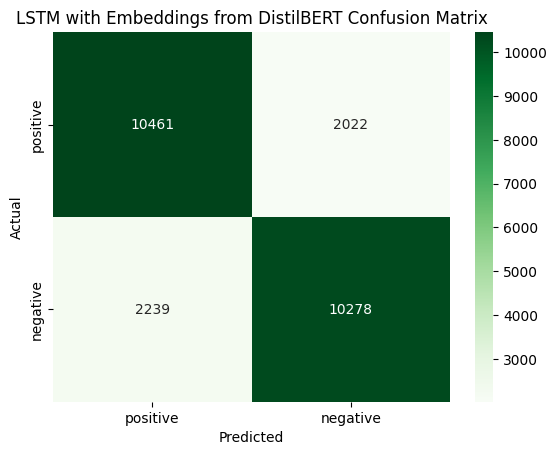

In [14]:
# Run Test
y_test, y_pre = test_model(model, test_loader)
print("LSTM with DistilBERT Features:")
evaluate_model(y_test, y_pre)
# Confusion matrix
textblob_cm = confusion_matrix(y_test, y_pre, labels=[0, 1])
sns.heatmap(textblob_cm, annot=True, fmt='d', cmap='Greens', xticklabels=['positive', 'negative'], yticklabels=['positive', 'negative'])
plt.title("LSTM with Embeddings from DistilBERT Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()